# Using PyMC for parameter estimation 
_______________
## Estimate parameters of ODE using Bayesian Inference on a smaller model 

### Motivation
I wanted to test whether I could code in **PyMC** and not have to use **R** to achieve the same result; i.e do parameter estimation using *Bayesian Inference*. So I used a smaller ODE model, that I had previously worked on and knew that a solution exists, to explore **PyMC** as well as develop a strategy to implement the more complex and more time consuming *Tunable Bandpass Filter Model*.

I used the data from strain characterization experiment I had done with Christian. the general scheme is glucose uptake by *GaLP*, followed by phosphorylation by *Glk* and eventual conversion to biomass. The unknown variables in the ODE system are the  velocities of the *GalP* and *Glk* reactions which are approximated by Bayesian Inference by the following routine.


In [1]:
import pymc as pm
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#importing experimental data
timedata=np.genfromtxt("data/timedata.txt", delimiter=',')
glc_concentration=np.genfromtxt("data/GLCexconc.txt", delimiter=',')

### Defining Priors
Properly defining priors is crucial. 
* Make sure that distribution covers the entire solution space
* If the solution space is too big, there's a chance that the entire solution space is not scanned (This happened when I defined the solution space as `pm.Uniform(1e3, 1e4)`
* If prior has probability zero for a point then posterior will as well
* It could be beneficial to bias the prior at some value just to boost convergence. (If we define prior as `Normal` distribution with $ \mu$ = expected value and a very large $\sigma$ for certain parameters rather than `Uniform` for all

In [3]:
#defining prior distributions of our unknown variables 
kcat_prob = pm.Uniform('kcat', 0.01, 1.0)
vmaxf_prob = pm.Uniform('vmaxf', 0.01, 1.0)

Deterministic variables are completely defined by their parents.
If you know the values of it's parents, you can calculate its value as well. 

In [4]:
# deterministic compartmental model

#initial conditions for concentration profile
tspan = timedata
initialBiomass=0.043 #gDwt/l
initialGLCexconc=21 #mM
initialGLCinconc=0
rho=564 #gdw/Lcell
metabolite0 = [initialGLCexconc, initialGLCinconc, initialBiomass] #Initial conditions

 

@pm.deterministic
def glk(kcat=kcat_prob, vmaxf=vmaxf_prob,tspan=tspan):
    def glk_model(metabolite, t):
        [GLCex,GLCin,Biomass]=metabolite
        
        #all constants in the model
        km=10.2e-3
        rho=564; #gDW/Lcell
        vmaxHKr=24e-6*1.16*3600 #mM/h
        KmATP=1
        KmG6P=47e-3
        KiATP=1
        KiGLC=47e-3
        KiG6P=47e-3
        KiADP=1
        ATP=1.54 #mM
        ADP=560e-3 #mM 
        G6P=0.801
        
        #Reactions in the model
        #denominator of glk reaction
        D=1+ ATP/KiATP+ G6P/KiG6P+ GLCin/KiGLC+ ADP/KiADP+ATP*GLCin/(KmATP*KiGLC)+ADP*G6P/(KiADP*KmG6P)
        #glk reaction
        VHK=(vmaxf*10000*ATP*GLCin/(KmATP*KiGLC)-vmaxHKr*ADP*G6P/(KiADP*KmG6P))/D 
        #GalP reaction
        VGalP=kcat*10000*GLCex/(km+GLCex) #GalP reaction
        #growth rate
        mu=(VHK/rho-0.4531)/10.971  
        if mu<=0:
            mu=0
        
        #Differential equations
        dglcex_dt=-VGalP*Biomass/rho #d(GLCex)/dt
        dglcin_dt=VGalP-VHK-mu*GLCin #d(GLCin)/dt
        dx_dt=mu*Biomass #d(biomass)/dt
        dmetabolite=[dglcex_dt,dglcin_dt,dx_dt]
        return dmetabolite
    #ODE solver call
    soln = odeint(glk_model, metabolite0, tspan)
    #Solution return
    GLCconc= soln[:,0]
    return [GLCconc]


Observed data will have the `observed=True` argument in its definition. Observed data must be able to satisfy any value defined by its parent function. 
High `tau` value indicates the confidence of observed data, $\tau=\frac{1}{\sigma^2}$
For the *Bandpass Model*, I might try a different distribution for observed data. I was thinking of maybe defining the observed data as a `binomial` distribution. Assigning the output of the Model as a *probability of growth* rather than *OD*. hence the probability near changeover points will be ~0.5 rather than strictly 0 or strictly 1.  


In [5]:
# data likelihood
observed_glc = pm.Normal('observed_glc', mu=glk,tau=1000,value=glc_concentration, observed=True)

Define the model for *Markov Chain Monte Carlo* Simulation.
`pm.MAP` function computes the *Maximum a posteriori* estimates
The model is then sampled to finf posterior distribution. Here we need to define the algorithm for MCMC (Metropolis, Hamiltonian etc.). I've stuck to default for now, but might need improvement if the problem is too complex to solve.
`burn` rejects the initial samples as they are biased to the initial position
`thin` defines the interval between samples recorded to remove the effects of auto-correlation
Hackett et al. used the `burn=8000` and `thin=300` taking 200 samples for 10 different starting positions
I havent figured out how to do multi-start. This workload could be parallelized to reduce computtional time. (have to figure this out as well)

In [6]:
model = pm.Model([kcat_prob,vmaxf_prob,glk,observed_glc])
 
# fit the model with mcmc
map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(5000, burn=400, thin=10)

 [-----------------100%-----------------] 5000 of 5000 complete in 118.3 sec

In [7]:
#MCMC samples turned to arrays
kcat_samples=mcmc.trace('kcat')[:]
vmaxf_samples=mcmc.trace('vmaxf')[:]

In [8]:
#means will be the estimated values of the variables
print('mean of kcat values:',round(kcat_samples.mean(),4),'\n')
print('mean of vmaxf values:',round(vmaxf_samples.mean(),4))

mean of kcat values: 0.2247 

mean of vmaxf values: 0.355


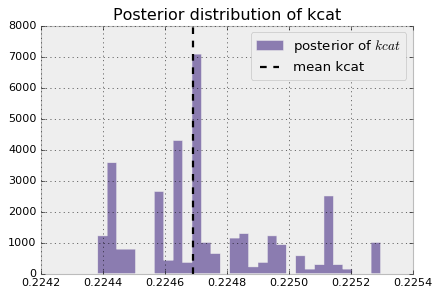

In [13]:
#Histogram of variable 1:kcat
plt.hist(kcat_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $kcat$", color="#7A68A6", normed=True);
plt.vlines(np.median(kcat_samples), 0, 8000, linestyle="--", label="mean kcat")
plt.legend(loc="upper right")
plt.title("Posterior distribution of kcat")

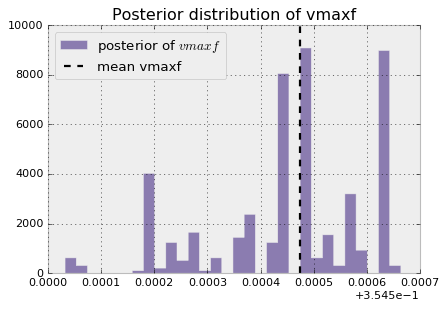

In [16]:
#histogram of Variable 2:vmaxf
plt.hist(vmaxf_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $vmaxf$", color="#7A68A6", normed=True);
plt.vlines(np.median(vmaxf_samples), 0, 10000, linestyle="--", label="mean vmaxf")
plt.legend(loc="upper left")
plt.title("Posterior distribution of vmaxf")

In [11]:
import json, matplotlib
s = json.load( open("styles/bmh_matplotlibrc.json") )
matplotlib.rcParams.update(s)

C:\Users\kadam\Anaconda3\lib\site-packages\matplotlib\__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
